In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
os.listdir('C:/Users/natan/DataScienceCoba/Skripsi Skin Cancer/data')

['ATTRIBUTION.txt', 'groundtruth.csv', 'image', 'LICENSE.txt', 'metadata.csv']

In [3]:
base_dir = os.path.join('data')
all_image_path = glob(os.path.join(base_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [4]:
df_original = pd.read_csv(os.path.join(base_dir, 'groundtruth.csv'))
df_original['path'] = df_original['image'].map(imageid_path_dict.get)

In [5]:
df_duplicate = df_original.copy()
df_duplicate["count"] = 1
df_duplicate = df_duplicate.groupby(['image'])["count"].count().reset_index()

In [6]:
print(df_duplicate[df_duplicate['count']>1])

Empty DataFrame
Columns: [image, count]
Index: []


In [7]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Others'
}

df_original = df_original.rename(columns=lesion_type_dict)

In [8]:
def get_disease(row):
    for i in df_original.iloc[:,1:].columns:
        if row[i] == 1.0:
            return i
        
df_new = df_original.apply(get_disease, axis=1)

In [26]:
df_new

0            Melanocytic Nevi
1            Melanocytic Nevi
2                    Melanoma
3            Melanocytic Nevi
4                    Melanoma
                 ...         
25326    Basal Cell Carcinoma
25327        Benign Keratosis
25328                Melanoma
25329        Melanocytic Nevi
25330        Benign Keratosis
Length: 25331, dtype: object

In [27]:
df_original

,image,Melanoma,Melanocytic Nevi,Basal Cell Carcinoma,Actinic Keratoses,Benign Keratosis,Dermatofibroma,Vascular Lesions,Squamous Cell Carcinoma,Others,path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0000000.jpg
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0000001.jpg
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0000002.jpg
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0000003.jpg
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0000004.jpg
...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0073247.jpg
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,data\image\ISIC_0073248.jpg
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0073249.jpg
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data\image\ISIC_0073251.jpg


In [9]:
df = pd.concat([df_original, df_new], axis=1)
df.rename(columns={0: 'disease'}, inplace=True)
df.drop(labels=df.iloc[:,0:10].columns, axis=1, inplace=True)
df = df[(df.disease == "Melanoma") | (df.disease == "Basal Cell Carcinoma") | (df.disease == "Squamous Cell Carcinoma")]

In [29]:
df

,path,disease
2,data\image\ISIC_0000002.jpg,Melanoma
4,data\image\ISIC_0000004.jpg,Melanoma
12,data\image\ISIC_0000013.jpg,Melanoma
21,data\image\ISIC_0000022_downsampled.jpg,Melanoma
25,data\image\ISIC_0000026_downsampled.jpg,Melanoma
...,...,...
25320,data\image\ISIC_0073238.jpg,Melanoma
25322,data\image\ISIC_0073241.jpg,Melanoma
25325,data\image\ISIC_0073246.jpg,Basal Cell Carcinoma
25326,data\image\ISIC_0073247.jpg,Basal Cell Carcinoma


In [10]:
df.loc[df['disease'] == 'Melanoma', ['disease']] = 'Melanoma'
df.loc[df['disease'] == 'Basal Cell Carcinoma', ['disease']] = 'Non-Melanoma'
df.loc[df['disease'] == 'Squamous Cell Carcinoma', ['disease']] = 'Non-Melanoma'

In [31]:
df['disease'].value_counts()

Melanoma        4522
Non-Melanoma    3951
Name: disease, dtype: int64

In [11]:
df['disease_id'] = [0 if x=='Non-Melanoma' else 1 for x in df['disease']]

In [33]:
df[['disease_id', 'disease']].sort_values('disease_id').drop_duplicates()

,disease_id,disease
16633,0,Non-Melanoma
19752,1,Melanoma


In [34]:
df

,path,disease,disease_id
2,data\image\ISIC_0000002.jpg,Melanoma,1
4,data\image\ISIC_0000004.jpg,Melanoma,1
12,data\image\ISIC_0000013.jpg,Melanoma,1
21,data\image\ISIC_0000022_downsampled.jpg,Melanoma,1
25,data\image\ISIC_0000026_downsampled.jpg,Melanoma,1
...,...,...,...
25320,data\image\ISIC_0073238.jpg,Melanoma,1
25322,data\image\ISIC_0073241.jpg,Melanoma,1
25325,data\image\ISIC_0073246.jpg,Non-Melanoma,0
25326,data\image\ISIC_0073247.jpg,Non-Melanoma,0


In [12]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((200, 200))))

In [13]:
def imageprocessing(img, show=True):
    # Convert the original image to grayscale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))

    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # intensify the hair countours in preparation for the inpainting algorithm
    ret, thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    inpaint = cv2.inpaint(img, thresh2, 1, cv2.INPAINT_TELEA)
    
    # gaussian filtering
#     blur = cv2.GaussianBlur(inpaint,(5,5),0)
    
    # median filtering
    image_final = cv2.medianBlur(inpaint,5)
    
    # Convert to grayscale
#     image_final = cv2.cvtColor(medianFiltered, cv2.COLOR_RGB2GRAY)
    
    # buat laporan
#     if show:
#         plt.imshow(img, cmap="gray")
#         plt.show()
#         plt.imshow(blackhat, cmap='gray')
#         plt.show()
#         plt.imshow(thresh2, cmap='gray')
#         plt.show()
#         plt.imshow(inpaint)
#         plt.show()
# #         plt.imshow(blur)
# #         plt.show()
#         plt.imshow(medianFiltered)
#         plt.show()
#         plt.imshow(image_final, cmap="gray")
#         plt.show()
        
    return image_final

In [20]:
def imageprocessing_show(img, show=True):
    # Convert the original image to grayscale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))

    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # intensify the hair countours in preparation for the inpainting algorithm
    ret, thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    inpaint = cv2.inpaint(img, thresh2, 1, cv2.INPAINT_TELEA)
    
    # gaussian filtering
#     blur = cv2.GaussianBlur(inpaint,(5,5),0)
    
    # median filtering
    image_final = cv2.medianBlur(inpaint,5)
    
    # Convert to grayscale
#     image_final = cv2.cvtColor(medianFiltered, cv2.COLOR_RGB2GRAY)
    
    # buat laporan
    if show:
        plt.imshow(img, cmap="gray")
        plt.show()
        plt.imshow(grayScale, cmap="gray")
        plt.show()
        plt.imshow(blackhat, cmap='gray')
        plt.show()
        plt.imshow(thresh2, cmap='gray')
        plt.show()
        plt.imshow(inpaint)
        plt.show()
#         plt.imshow(blur)
#         plt.show()
        plt.imshow(image_final, cmap="gray")
        plt.show()
        
    return image_final

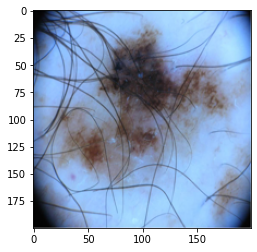

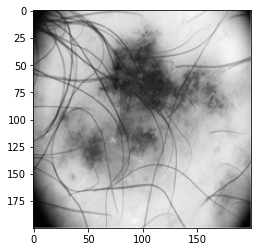

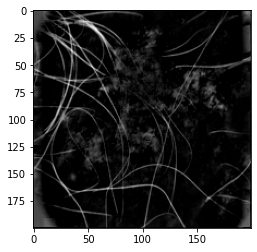

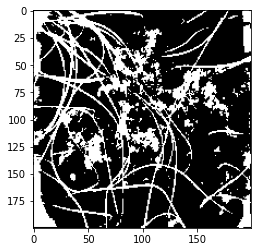

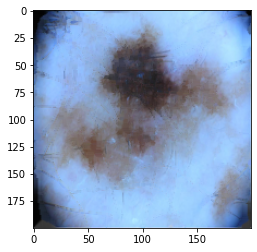

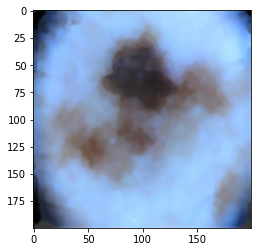

array([[[55, 55, 55],
        [55, 55, 55],
        [55, 55, 55],
        ...,
        [ 6,  6, 10],
        [ 6,  6, 10],
        [ 4,  4,  6]],

       [[43, 43, 43],
        [43, 43, 43],
        [38, 38, 38],
        ...,
        [ 6,  6, 10],
        [ 4,  4,  5],
        [ 3,  3,  3]],

       [[42, 42, 42],
        [38, 38, 38],
        [ 4,  4,  4],
        ...,
        [ 4,  4,  8],
        [ 4,  4,  4],
        [ 3,  3,  3]],

       ...,

       [[41, 41, 41],
        [41, 41, 41],
        [41, 41, 41],
        ...,
        [56, 56, 56],
        [56, 56, 56],
        [56, 56, 56]],

       [[41, 41, 41],
        [45, 45, 45],
        [53, 53, 53],
        ...,
        [56, 56, 56],
        [56, 56, 56],
        [56, 56, 56]],

       [[53, 53, 53],
        [55, 55, 55],
        [56, 56, 56],
        ...,
        [56, 56, 56],
        [56, 56, 56],
        [56, 56, 56]]], dtype=uint8)

In [39]:
imageprocessing_show(df['image'].iloc[16])

In [14]:
df['new_image'] = df['image'].map(lambda x: imageprocessing(x)/255.0)

In [15]:
X = df['new_image']
y = df['disease_id']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=30405, 
                                                    stratify=y)

In [23]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.80, random_state=30405,
                                                           stratify=y_train)
#Split dataset into 10% of validation from training set

In [48]:
len(X_train)

5422

In [33]:
len(X_validate)

1356

In [23]:
len(X_test)

1695

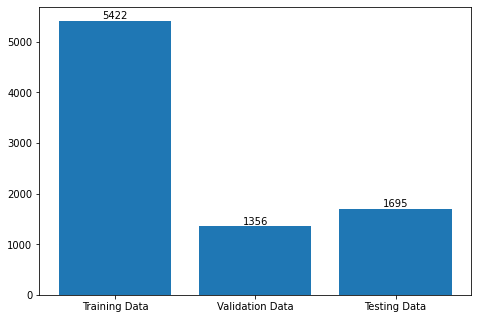

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Training Data', 'Validation Data', 'Testing Data']
count = [len(X_train), len(X_validate), len(X_test)]
ax.bar(label,count)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

In [24]:
X_train = np.asarray(X_train.tolist())
X_test = np.asarray(X_test.tolist())
X_validate = np.asarray(X_validate.tolist())

In [25]:
nsamples, nx, ny, ndim = X_train.shape

In [26]:
X_train_resample = X_train.reshape(nsamples, nx * ny * ndim)

In [22]:
X_train.reshape(-1, nx, ny, ndim).shape

(5422, 200, 200, 3)

In [45]:
y_train.value_counts()

1    2893
0    2529
Name: disease_id, dtype: int64

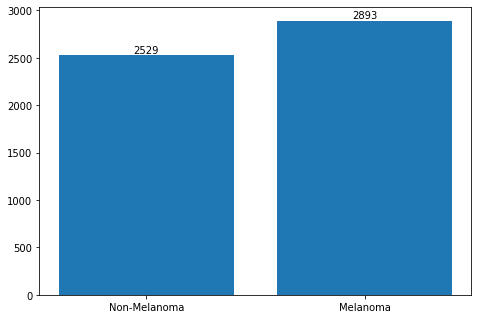

In [77]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Non-Melanoma', 'Melanoma']
count = [y_train.value_counts()[0], y_train.value_counts()[1]]
ax.bar(label,count)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

In [27]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=30405)
X_over_resampled, y_over_resampled = ros.fit_resample(X_train_resample, y_train)

In [30]:
y_over_resampled.value_counts()

1    2893
0    2893
Name: disease_id, dtype: int64

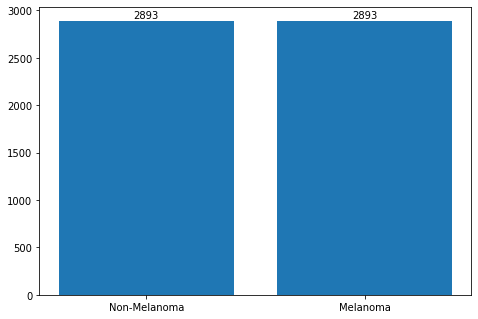

In [79]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Non-Melanoma', 'Melanoma']
count = [y_over_resampled.value_counts()[0], y_over_resampled.value_counts()[1]]
ax.bar(label,count)
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

In [28]:
X_over_resampled = X_over_resampled.reshape(-1, nx, ny, ndim)

In [34]:
X_over_resampled.shape

(5786, 200, 200, 3)

In [29]:
X_train = X_over_resampled
y_train = y_over_resampled

In [30]:
# one hot encoding 
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encodin
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_validate = to_categorical(y_validate, num_classes=2)

In [24]:
# With data augmentation to prevent overfitting 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

## AlexNet

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

input_shape = (200, 200, 3)

model_AlexNet=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')  
])
model_AlexNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 128)       46592     
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 256)       819456    
_________________________________________________________________
batch_normalization_16 (Batc (None, 24, 24, 256)       1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)        

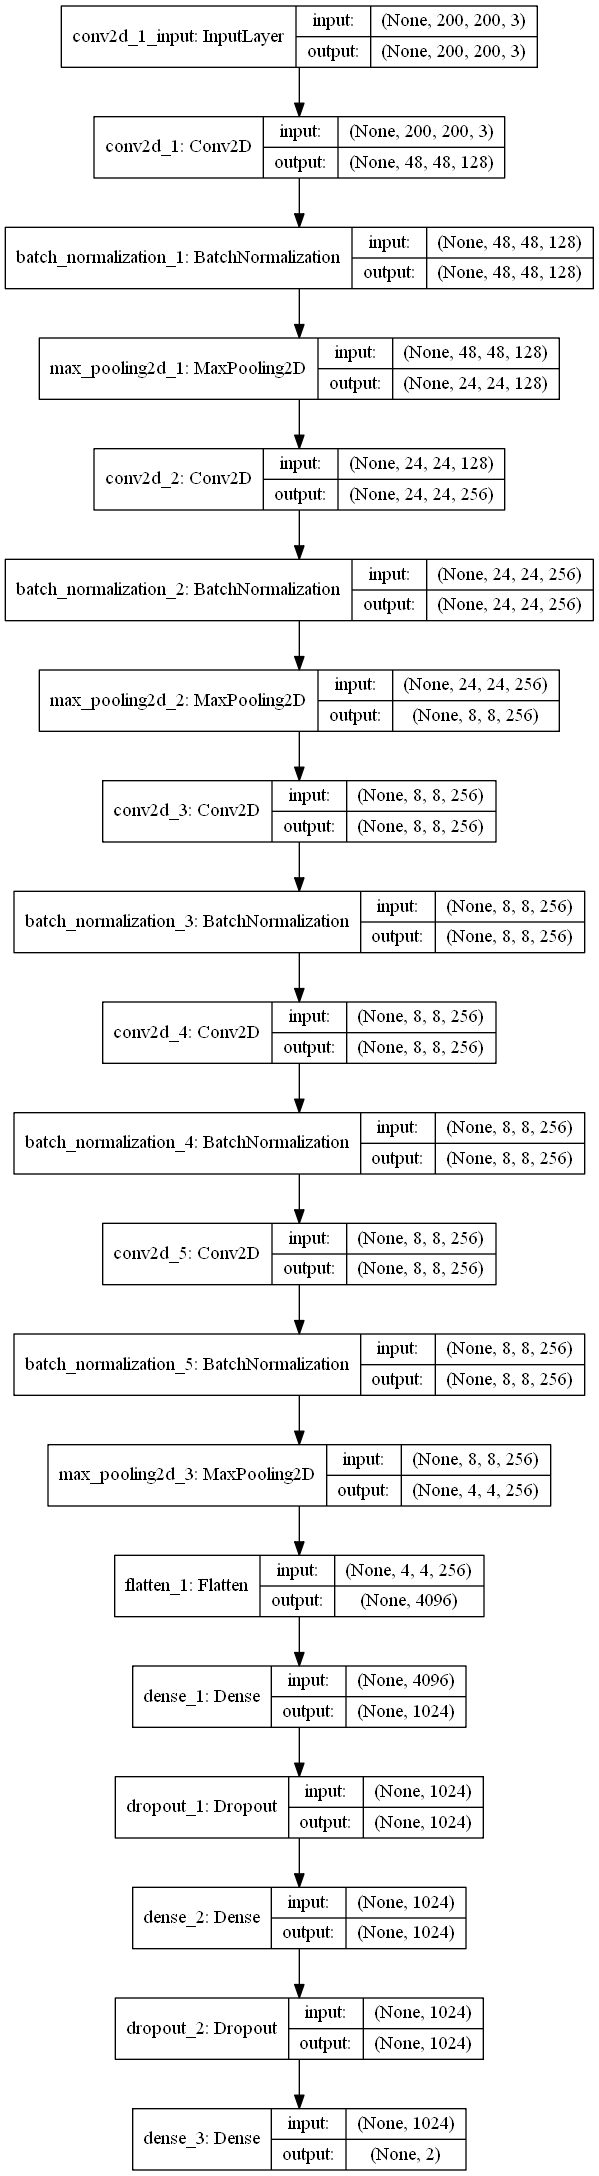

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model_AlexNet, "model_AlexNet.png")
plot_model(model_AlexNet, "modelshape_AlexNet.png", show_shapes=True)

In [67]:
# Compile the model
optimizer = Adam(lr=0.001)
model_AlexNet.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [68]:
# Set a learning rate annealer
checkpoint = ModelCheckpoint('model/model_AlexNet_best.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [69]:
# Fit the model (best model)
epochs = 50
batch_size = 32

h = model_AlexNet.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (X_validate, y_validate), 
                        steps_per_epoch=len(X_train) // batch_size, callbacks=[checkpoint, learning_rate_reduction])

Epoch 1/50
179/180 [============================>.] - ETA: 2s - loss: 1.4028 - acc: 0.6912
Epoch 00001: val_acc improved from -inf to 0.50885, saving model to model/model_AlexNet_best.h5
180/180 [==============================] - 398s 2s/step - loss: 1.3978 - acc: 0.6919 - val_loss: 1.2369 - val_acc: 0.5088
Epoch 2/50
179/180 [============================>.] - ETA: 1s - loss: 0.5700 - acc: 0.7599
Epoch 00002: val_acc improved from 0.50885 to 0.76401, saving model to model/model_AlexNet_best.h5
180/180 [==============================] - 360s 2s/step - loss: 0.5703 - acc: 0.7596 - val_loss: 0.5256 - val_acc: 0.7640
Epoch 3/50
179/180 [============================>.] - ETA: 1s - loss: 0.4721 - acc: 0.7906
Epoch 00003: val_acc did not improve from 0.76401
180/180 [==============================] - 370s 2s/step - loss: 0.4716 - acc: 0.7906 - val_loss: 0.5470 - val_acc: 0.7323
Epoch 4/50
179/180 [============================>.] - ETA: 1s - loss: 0.4477 - acc: 0.7994
Epoch 00004: val_acc did 

Epoch 30/50
179/180 [============================>.] - ETA: 1s - loss: 0.2499 - acc: 0.8892
Epoch 00030: val_acc did not improve from 0.86947
180/180 [==============================] - 341s 2s/step - loss: 0.2492 - acc: 0.8896 - val_loss: 0.3293 - val_acc: 0.8680
Epoch 31/50
179/180 [============================>.] - ETA: 1s - loss: 0.2337 - acc: 0.8958
Epoch 00031: val_acc improved from 0.86947 to 0.87168, saving model to model/model_AlexNet_best.h5
180/180 [==============================] - 342s 2s/step - loss: 0.2340 - acc: 0.8954 - val_loss: 0.3193 - val_acc: 0.8717
Epoch 32/50
179/180 [============================>.] - ETA: 1s - loss: 0.2375 - acc: 0.9025
Epoch 00032: val_acc did not improve from 0.87168
180/180 [==============================] - 339s 2s/step - loss: 0.2374 - acc: 0.9027 - val_loss: 0.3234 - val_acc: 0.8665
Epoch 33/50
179/180 [============================>.] - ETA: 2s - loss: 0.2356 - acc: 0.8943
Epoch 00033: val_acc did not improve from 0.87168
180/180 [========

In [70]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(h.history) 

# or save to csv: 
hist_csv_file = 'history/model_AlexNet.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [72]:
h = pd.read_csv('history/model_AlexNet.csv')

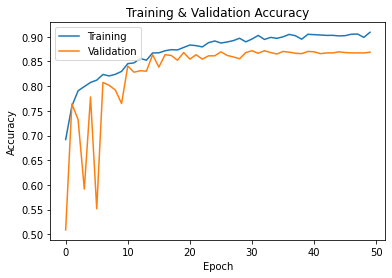

In [75]:
import matplotlib.pyplot as plt
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('Training & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

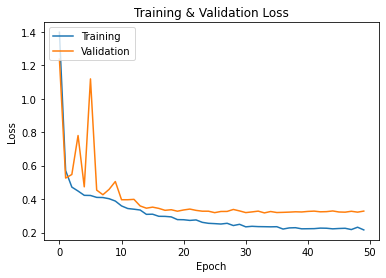

In [76]:
import matplotlib.pyplot as plt
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### Best Model AlexNet

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

input_shape = (200, 200, 3)

loaded_model_AlexNet=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')  
])
loaded_model_AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 256)       819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         5

In [18]:
loaded_model_AlexNet.load_weights("model/model_AlexNet_best.h5")

In [31]:
from sklearn.metrics import accuracy_score
# test the model
y_pred = loaded_model_AlexNet.predict(X_test, batch_size=32)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.8684365781710914


In [32]:
#Confusion Matrix
import sklearn
from sklearn.metrics import confusion_matrix
cm=sklearn.metrics.confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1))
print(cm)

[[700 133]
 [ 90 772]]


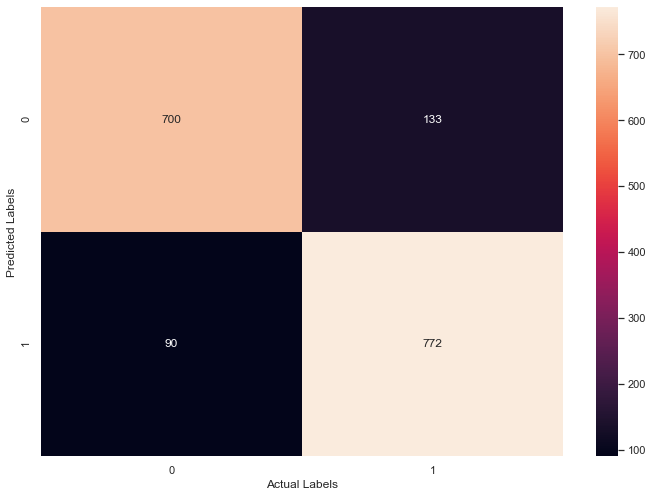

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(cm, annot=True, fmt='.4g')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [49]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), labels=[0,1], digits=5))

              precision    recall  f1-score   support

           0    0.84034   0.88608   0.86260       790
           1    0.89559   0.85304   0.87380       905

    accuracy                        0.86844      1695
   macro avg    0.86796   0.86956   0.86820      1695
weighted avg    0.86984   0.86844   0.86858      1695



In [87]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
print('Precision : {}'.format(precision))
print('Recall    : {}'.format(recall))
print('F1-Score   : {}'.format(fscore))
# print('Support   : {}'.format(support))

Precision : 0.867963890892784
Recall    : 0.8695573117001189
F1-Score   : 0.8681987599730947


### End of Best AlexNet

## LeNet

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

input_shape = (200, 200, 3)

model_LeNet=keras.models.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(120,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(84,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')  
])
model_LeNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 6)       456       
_________________________________________________________________
batch_normalization (BatchNo (None, 196, 196, 6)       24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [26]:
# Compile the model
optimizer = Adam(lr=0.001)
model_LeNet.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [27]:
# Set a learning rate annealer
checkpoint = ModelCheckpoint('model/model_LeNet_best.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [28]:
# Fit the model (best model)
epochs = 50
batch_size = 32

h = model_LeNet.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (X_validate, y_validate), 
                        steps_per_epoch=len(X_train) // batch_size, callbacks=[checkpoint, learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
180/180 [==============================] - ETA: 0s - loss: 3.1890 - accuracy: 0.6164WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001643F262B88> and will run it as-is.
Please report this to the TensorFlow team. When filing

Epoch 21/50
180/180 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8179
Epoch 00021: val_accuracy did not improve from 0.82301
180/180 [==============================] - 250s 1s/step - loss: 0.3984 - accuracy: 0.8179 - val_loss: 0.4143 - val_accuracy: 0.8164
Epoch 22/50
180/180 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8273
Epoch 00022: val_accuracy improved from 0.82301 to 0.82743, saving model to model\model_lenet_best.h5
180/180 [==============================] - 240s 1s/step - loss: 0.3900 - accuracy: 0.8273 - val_loss: 0.4029 - val_accuracy: 0.8274
Epoch 23/50
180/180 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8267
Epoch 00023: val_accuracy improved from 0.82743 to 0.83628, saving model to model\model_lenet_best.h5
180/180 [==============================] - 241s 1s/step - loss: 0.3759 - accuracy: 0.8267 - val_loss: 0.3959 - val_accuracy: 0.8363
Epoch 24/50
180/180 [==============================] -

Epoch 48/50
180/180 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8490
Epoch 00048: val_accuracy did not improve from 0.85177

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-05.
180/180 [==============================] - 260s 1s/step - loss: 0.3398 - accuracy: 0.8490 - val_loss: 0.3697 - val_accuracy: 0.8473
Epoch 49/50
180/180 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8521
Epoch 00049: val_accuracy did not improve from 0.85177
180/180 [==============================] - 255s 1s/step - loss: 0.3376 - accuracy: 0.8521 - val_loss: 0.3697 - val_accuracy: 0.8473
Epoch 50/50
180/180 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8514
Epoch 00050: val_accuracy did not improve from 0.85177
180/180 [==============================] - 243s 1s/step - loss: 0.3312 - accuracy: 0.8514 - val_loss: 0.3696 - val_accuracy: 0.8473


In [29]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(h.history) 

# or save to csv: 
hist_csv_file = 'history/model_LeNet.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [31]:
h = pd.read_csv('history/model_LeNet.csv')

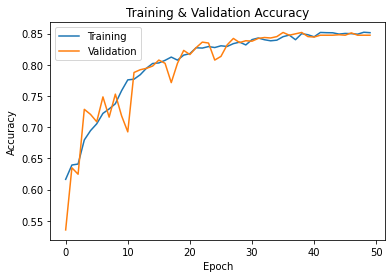

In [32]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

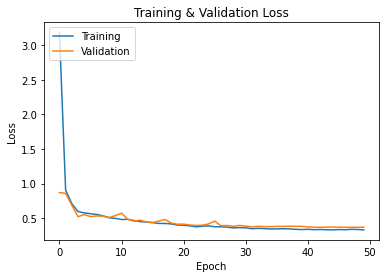

In [33]:
import matplotlib.pyplot as plt
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### Best Model LeNet

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

input_shape = (200, 200, 3)

loaded_model_LeNet=keras.models.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(120,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(84,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')  
])
loaded_model_LeNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 196, 196, 6)       456       
_________________________________________________________________
batch_normalization_5 (Batch (None, 196, 196, 6)       24        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 98, 98, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 98, 16)        2416      
_________________________________________________________________
batch_normalization_6 (Batch (None, 98, 98, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [36]:
loaded_model_LeNet.load_weights("model/model_LeNet_best.h5")

In [37]:
from sklearn.metrics import accuracy_score
# test the model
y_pred = loaded_model_LeNet.predict(X_validate, batch_size=32)
print(accuracy_score(np.argmax(y_validate, axis=1), np.argmax(y_pred, axis=1)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.8517699115044248


In [38]:
from sklearn.metrics import accuracy_score
# test the model
y_pred = loaded_model_LeNet.predict(X_test, batch_size=32)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

0.8348082595870207


In [39]:
#Confusion Matrix
import sklearn
from sklearn.metrics import confusion_matrix
cm=sklearn.metrics.confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1))
print(cm)

[[663 153]
 [127 752]]


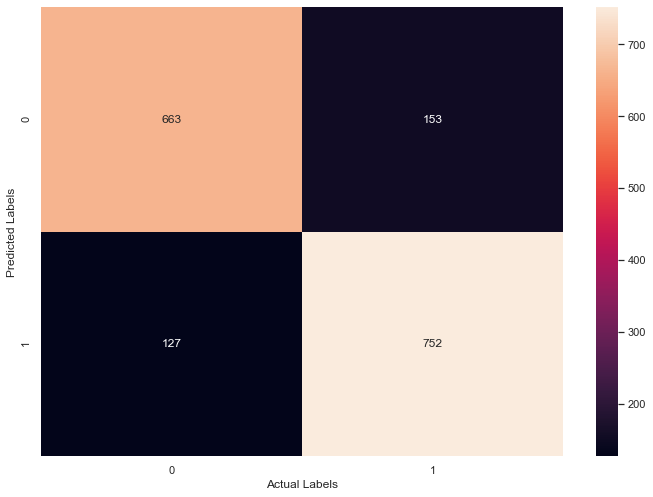

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(cm, annot=True, fmt='.4g')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [43]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), labels=[0,1], digits=5))

              precision    recall  f1-score   support

           0    0.81250   0.83924   0.82565       790
           1    0.85552   0.83094   0.84305       905

    accuracy                        0.83481      1695
   macro avg    0.83401   0.83509   0.83435      1695
weighted avg    0.83547   0.83481   0.83494      1695



In [44]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='macro')
print('Precision : {}'.format(precision))
print('Recall    : {}'.format(recall))
print('F1-Score   : {}'.format(fscore))
# print('Support   : {}'.format(support))

Precision : 0.8340088168373152
Recall    : 0.8350898664242254
F1-Score   : 0.834351562805399


### End of Best LeNet